In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# finds the corresponding bin for a data value
def find_bin(points, value) -> int:
    # TODO there is a formula, no need to bisect here
    from bisect import bisect
    idx = bisect(points, value)
    #print(f"idx: {idx} - value: {value}")
    return idx-1
def jitter(point, estimated, value) -> float:
    # finds the bin for the point
    bin = find_bin(point, value)
    width = estimated[bin]
    position = np.random.uniform(-width, width)
    return position
def multi_sina_plot(values: dict[str, list[float]], offset=1, scaling=5, n_bins=512, show_violin=False, title="Sina Plot"):
    import matplotlib.mlab as mlab
    plt.figure(figsize=(8,6))
    # color palette = set 2
    palette = sns.color_palette("Set2", n_colors=len(values))
    off = 0
    for label, vals in values.items():
        kde = mlab.GaussianKDE(vals, None)
        points = np.linspace(min(vals), max(vals), n_bins)
        estimated = kde.evaluate(points)
        estimated = estimated * scaling
        x_pos = [jitter(points, estimated, v)+off for v in vals]
        if show_violin:
            x_violin = list(estimated + off)
            x_violin.extend(reversed(off - estimated))
            y_violin = list(points) + list(reversed(points))
            plt.fill(x_violin, y_violin, c='0.5', alpha=0.3)
        plt.plot(x_pos, vals, '.', label=label, color=palette[off])
        off += offset
    ax = plt.gca()
    plt.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False)
    format='pdf'
    # draw a line at y=1
    plt.axhline(y=1, color='r', linestyle='--', linewidth=1)
    plt.xticks([i for i in range(len(values))], ['' for _ in range(len(values))])
    ax.set_ylabel(title, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(rotation=90)
    ax.grid(axis='y')
    plt.savefig(f"sinaplot.{format}", format=format, bbox_inches="tight")
    plt.show()



def multi_sina_plot_dual(values_left: dict[str, list[float]],
                         values_right: dict[str, list[float]],
                         offset=1, scaling=5, n_bins=512, 
                         show_violin=False,
                         title_left="Left",
                         title_right="Right",
                         figsize=(14,4)
                         , filename=None):

    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],   # Specifically Times New Roman
})

    # ---- Shared labels ----
    labels = list(values_left.keys())  # must match right dict
    num_labels = len(labels)

    # ---- One shared color per label ----
    palette = sns.color_palette("Set2", n_colors=num_labels)

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
    ax_left, ax_right = axes

    # ------- Helper -------
    def plot_one(ax, values, title):
        off = 0
        for color, label in zip(palette, labels):
            vals = np.asarray(values[label])

            # KDE
            kde = gaussian_kde(vals)
            points = np.linspace(vals.min(), vals.max(), n_bins)
            envelope = kde(points) * scaling  # violin half-width

            # interpolate envelope height at each y value
            widths = np.interp(vals, points, envelope)

            # uniform jitter bounded within violin
            x_pos = off + (np.random.rand(len(vals)) * 2 - 1) * widths

            # draw violin
            if show_violin:
                ax.fill(
                    np.concatenate([off + envelope, off - envelope[::-1]]),
                    np.concatenate([points, points[::-1]]),
                    color="0.85", alpha=0.4
                )

            # draw points
            ax.plot(x_pos, vals, '.', color=color, label=label)

            off += offset

        ax.axhline(1, color='r', linestyle='--', linewidth=1)
        ax.grid()
        ax.set_title(title, fontsize=16)
        ax.set_xticks([])
        ax.grid(axis='y')
        ax.set_yscale("log", base=2)

    # ---- Draw subplots ----
    plot_one(ax_left, values_left, title_left)
    plot_one(ax_right, values_right, title_right)



    # ---- ONE combined legend (2 labels only!) ----
    fig.legend(
        handles=[plt.Line2D([], [], marker='o', linestyle='', color=palette[i]) for i in range(num_labels)],
        labels=labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=num_labels,
        fontsize=18,
        frameon=False
    )
    fig.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

def multi_sina_plot_multi(
    datasets: dict[str, dict[str, list[float]]], 
    offset=1, 
    scaling=5, 
    n_bins=512,
    show_violin=False,
    shared_scale=False,
    figsize=(14,4),
    filename=None
):

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import gaussian_kde

    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],  # Specifically Times New Roman
})

    # ---- All subplot titles ----
    subplot_titles = list(datasets.keys())
    K = len(subplot_titles)

    # ---- Labels from first dict (all dicts must match) ----
    labels = list(next(iter(datasets.values())).keys())
    num_labels = len(labels)

    # ---- Colors ----
    palette = sns.color_palette("Set2", n_colors=num_labels)

    # ---- Axes ----
    fig, axes = plt.subplots(1, K, figsize=figsize, sharey=shared_scale)
    if K == 1:
        axes = [axes]

    # ---- Helper: plot one dataset ----
    def plot_single_subplot(ax, values_dict, title):
        off = 0
        for color, label in zip(palette, labels):
            vals = np.asarray(values_dict[label])

            # KDE
            kde = gaussian_kde(vals)
            points = np.linspace(vals.min(), vals.max(), n_bins)
            envelope = kde(points) * scaling

            # interpolate individual widths
            widths = np.interp(vals, points, envelope)

            # jitter
            x_pos = off + (np.random.rand(len(vals))*2 - 1) * widths

            # violin
            if show_violin:
                ax.fill(
                    np.concatenate([off + envelope, off - envelope[::-1]]),
                    np.concatenate([points, points[::-1]]),
                    color="0.85", alpha=0.4
                )

            # scatter
            ax.plot(x_pos, vals, '.', color=color)

            off += offset
        ax.axhline(1, color='r', linestyle='--', linewidth=1)
        ax.set_title(title, fontsize=22)
        ax.set_xticks([])
        ax.set_yscale("log", base=2)

    # ---- Build all subplots ----
    for ax, title in zip(axes, subplot_titles):
        plot_single_subplot(ax, datasets[title], title)
        ax.grid(axis='y', which='both', zorder=0)
        # make label font size bigger
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='both', which='minor', labelsize=18)


    # ---- Combined Legend ----
    fig.legend(
        handles=[plt.Line2D([], [], marker='o', linestyle='', color=palette[i]) 
                 for i in range(num_labels)],
        labels=labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=num_labels,
        fontsize=18,
        frameon=False
    )

    fig.tight_layout()

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

    plt.show()





def doubleScatter(df,time, nodes,  title):
    # 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    # scatter plot time
    ax1.scatter(df["timeBase"], df[time], alpha=0.5)
    # log scale
    ax1.set_xscale("log")
    ax1.set_yscale("log")

    ax2.scatter(df["nodesBase"], df[nodes], alpha=0.5)
    # log scale
    ax2.set_xscale("log")
    ax2.set_yscale("log")

    # set labels
    ax1.set_xlabel("Base Time", fontsize=14)
    ax1.set_ylabel(f"{time}", fontsize=14)
    ax2.set_xlabel("Base Nodes", fontsize=14)
    ax2.set_ylabel(f"{nodes}", fontsize=14)
    # set title
    fig.suptitle(title, fontsize=16)
    # draw a line y=x on both plots
    ax1.plot([1, max(df["timeBase"].max(), df[time].max())], [1, max(df["timeBase"].max(), df[time].max())], color='r', linestyle='--')
    ax2.plot([1, max(df["nodesBase"].max(), df[nodes].max())], [1, max(df["nodesBase"].max(), df[nodes].max())], color='r', linestyle='--')
    plt.show()

def scatter(df, x_method, y_method, spec, title = ""):
    plt.figure(figsize=(10, 10))

    plt.scatter(df[x_method], df[y_method], alpha=0.5, )
    #plt.xscale("log", base=10)
    #plt.yscale("log", base=10)
    # more ticks on the axis
    plt.xlabel("Relaxed BC Filtering", fontsize=30)
    plt.ylabel("Precedence Extraction", fontsize=30)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.gca().grid(True, which="both", linestyle="--", linewidth=0.5)

    
    # draw a line y=x
    plt.plot([min(df[x_method].min(), df[y_method].min()), max(df[x_method].max(), df[y_method].max())], [min(df[x_method].min(), df[y_method].min()), max(df[x_method].max(), df[y_method].max())], color='r', linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{title}.pdf", bbox_inches="tight", pad_inches=0.1)

    plt.show()
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def scatter_by_spec(df, x_method, y_method, spec, title="", specName="W"):
    unique_vals = df[spec].unique()
    n = len(unique_vals)

    # Global min/max across BOTH axes (required for correct diagonal)
    global_min = min(df[x_method].min(), df[y_method].min())
    global_max = max(df[x_method].max(), df[y_method].max())

    fig, axes = plt.subplots(1, n, figsize=(7 * n, 7), sharey=True, squeeze=False)
    first = True

    for ax, val in zip(axes[0], unique_vals):

        sub = df[df[spec] == val]

        ax.scatter(sub[x_method], sub[y_method], alpha=0.5)
        ax.set_xscale("log", base=10)
        ax.set_yscale("log", base=10)

        ax.set_xlabel("Relaxed BC Filtering", fontsize=22)

        if first:
            ax.set_ylabel("Precedence Extraction", fontsize=22)
            first = False

        # Apply shared limits (so diagonal aligns perfectly)
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(global_min, global_max)


        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        # GLOBAL diagonal (always bottom-left to top-right)
        ax.plot([global_min, global_max],
                [global_min, global_max],
                linestyle="--", color="red")

        ax.set_title(f"{specName} = {val}", fontsize=22)

    # Remove y-tick labels except for first subplot
    show_label = True
    for ax in axes[0]:
        ax.tick_params(axis='y', which='both', labelleft=show_label, labelsize=18)
        show_label = False

    plt.tight_layout()
    if title:
        plt.savefig(f"{title}.pdf", dpi=300)
    plt.show()



In [352]:
df = pd.read_csv("jit-new", sep=",")

In [353]:
# remove lines where timeBase < 1000ms
df = df[df["timeBase"] >= 1000]
df = df[df["loadfactor"] == 1]

# -------------------------------------------------------
# 1. Compute % change Base → TW for time and nodes
# -------------------------------------------------------
df["time_pct_TW"]  = df["timeBase"]    / df["timeTW"]   
df["nodes_pct_TW"] = df["nbNodesBase"] / df["nbNodesTW"] 
df["time_pct_Pred"]  = df["timeBase"]    / df["timePred"]   
df["nodes_pct_Pred"] = df["nbNodesBase"] / df["nbNodesPred"]

In [354]:
# print mean, meadian, stddev for time_pct_TW and time_pct_Pred and nodes_pct_TW and nodes_pct_Pred
dffiltered = df[(df["loadfactor"] == 1)]
for col in ["time_pct_TW", "time_pct_Pred", "nodes_pct_TW", "nodes_pct_Pred"]:
    print(f"{col}: mean={dffiltered[col].mean():.2f}, median={dffiltered[col].median():.2f}, stddev={dffiltered[col].std():.2f}")


time_pct_TW: mean=0.99, median=0.85, stddev=0.71
time_pct_Pred: mean=0.77, median=0.66, stddev=0.56
nodes_pct_TW: mean=1.67, median=1.36, stddev=1.20
nodes_pct_Pred: mean=1.58, median=1.30, stddev=1.04


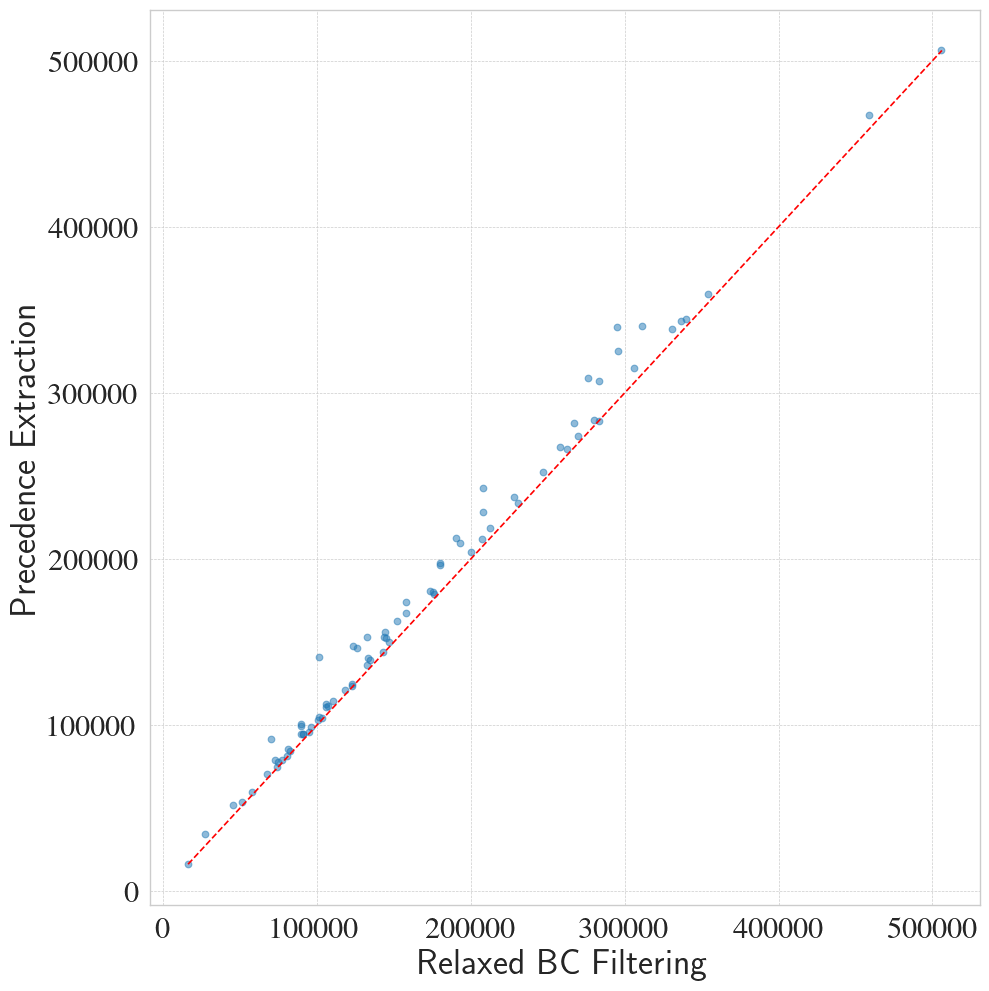

In [355]:
scatter(df[df["mddSize"] == 32], "nbNodesTW", "nbNodesPred", "mddSize", "scatter32")

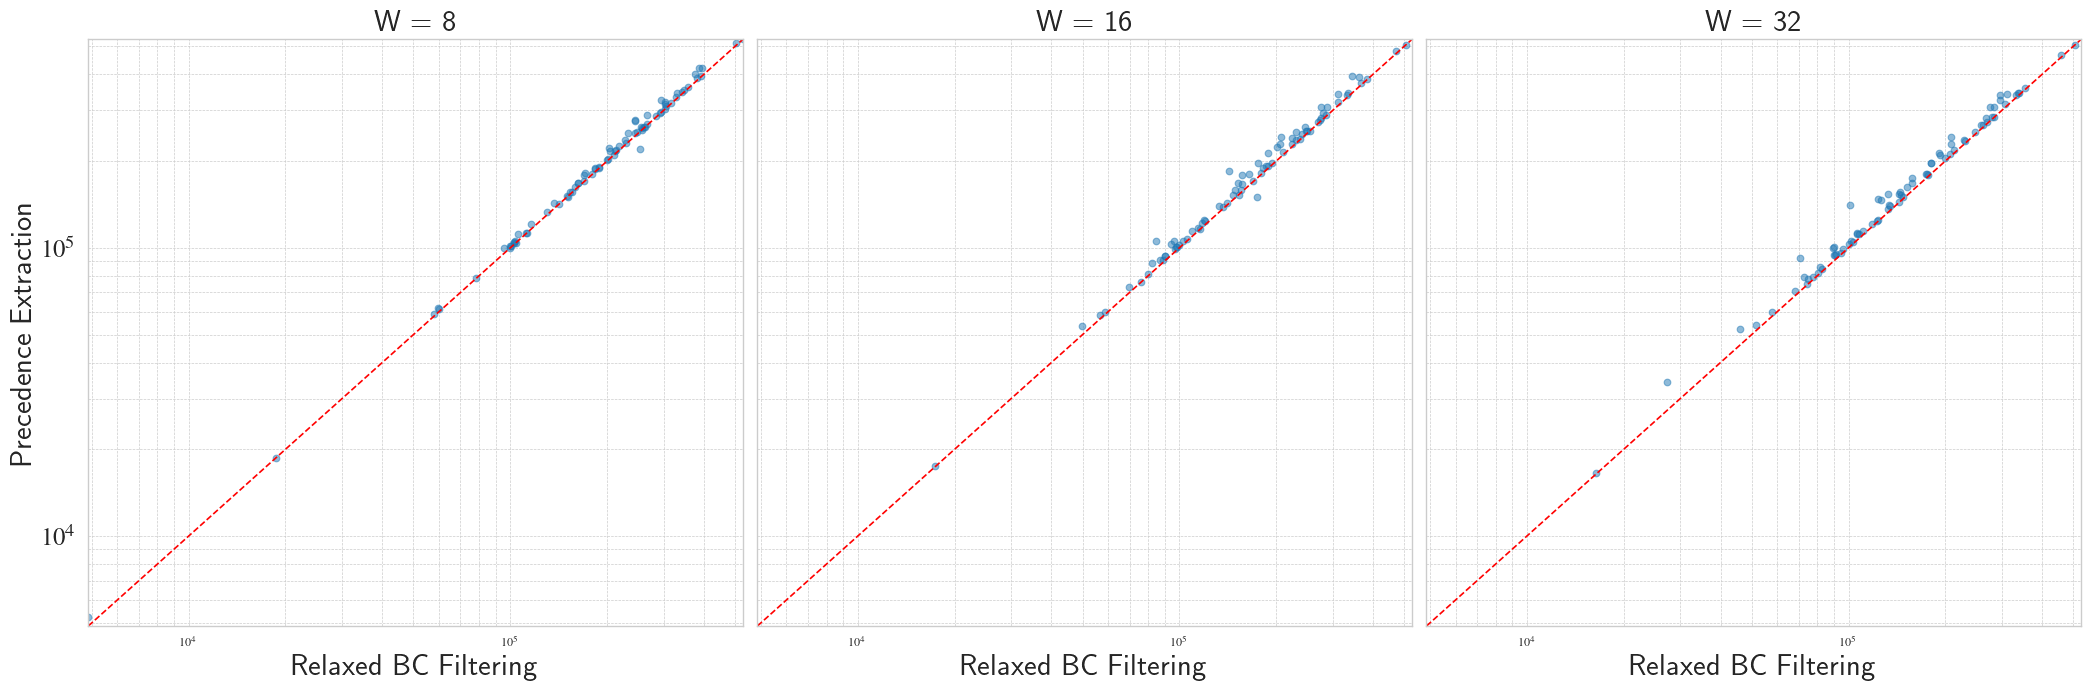

In [356]:
scatter_by_spec(df, "nbNodesTW", "nbNodesPred", "mddSize", "scatterNodeByMDDSize", "W")

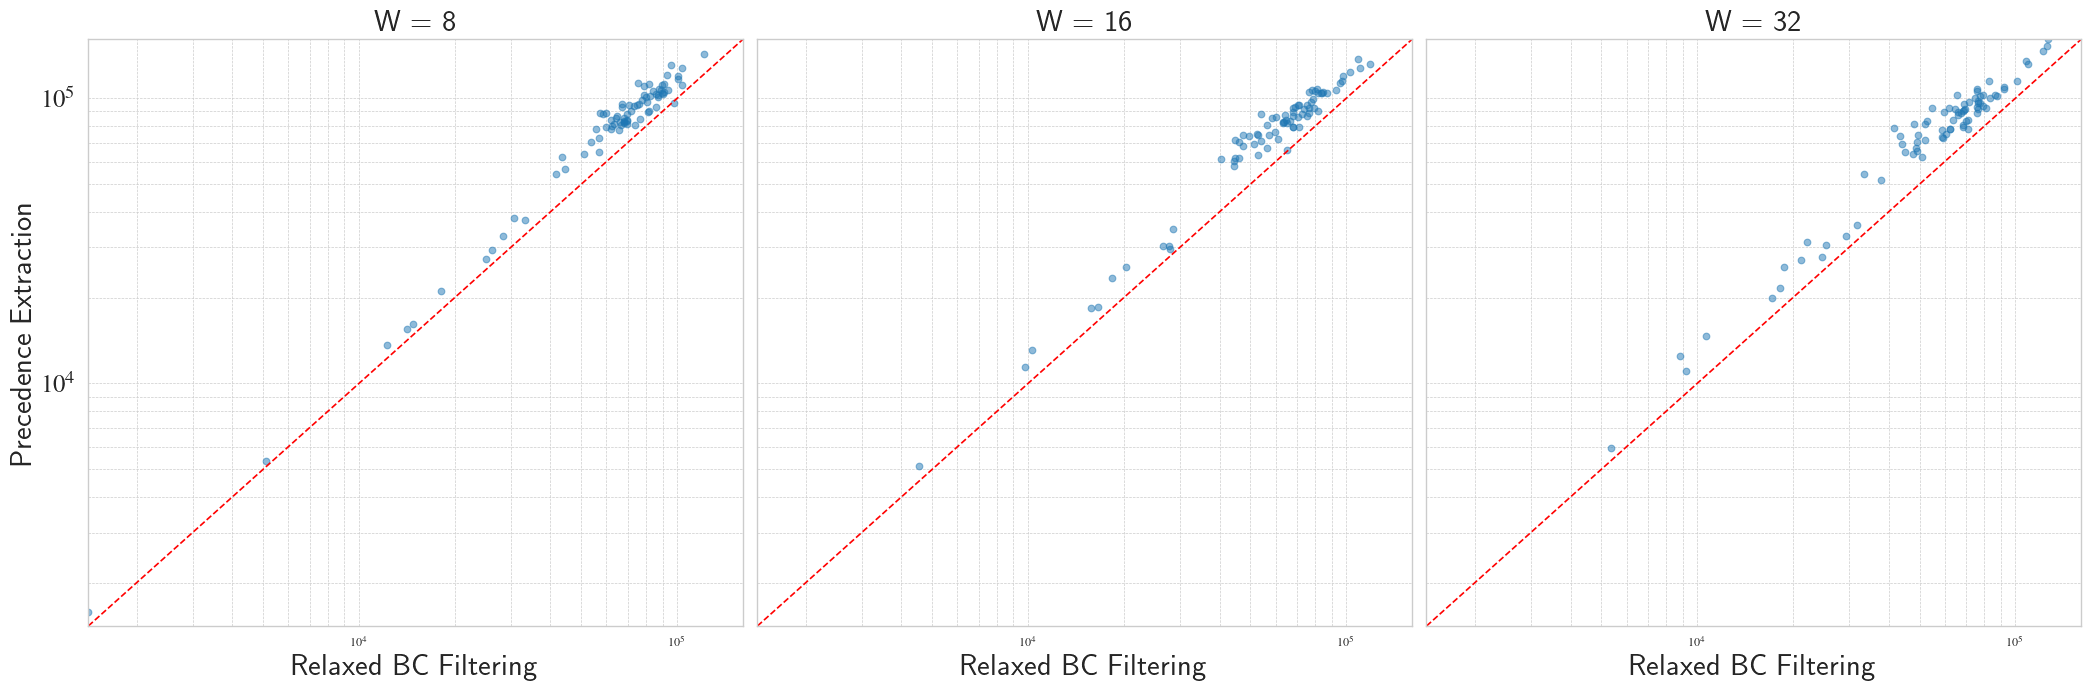

In [357]:
scatter_by_spec(df, "timeTW", "timePred", "mddSize", "scatterTimeByMDDSize", "W")

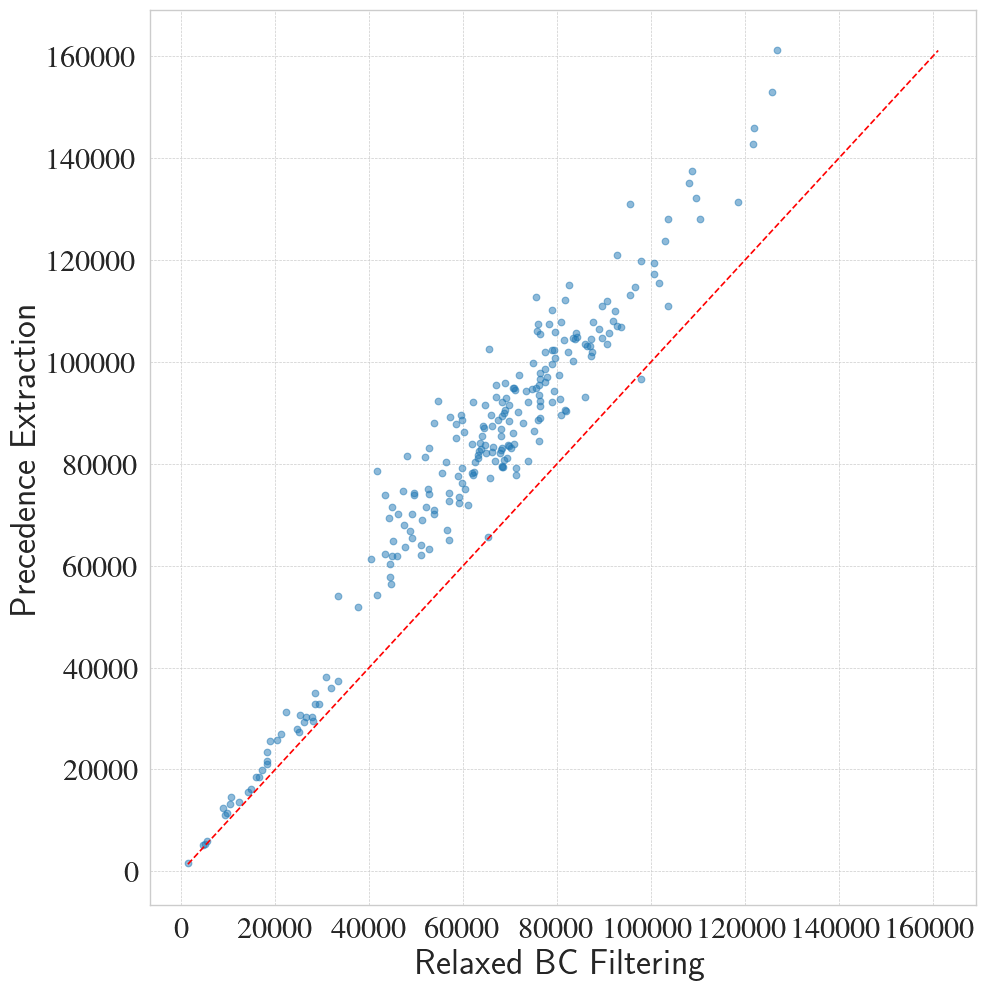

In [358]:
scatter(df, "timeTW", "timePred", "mddSize")

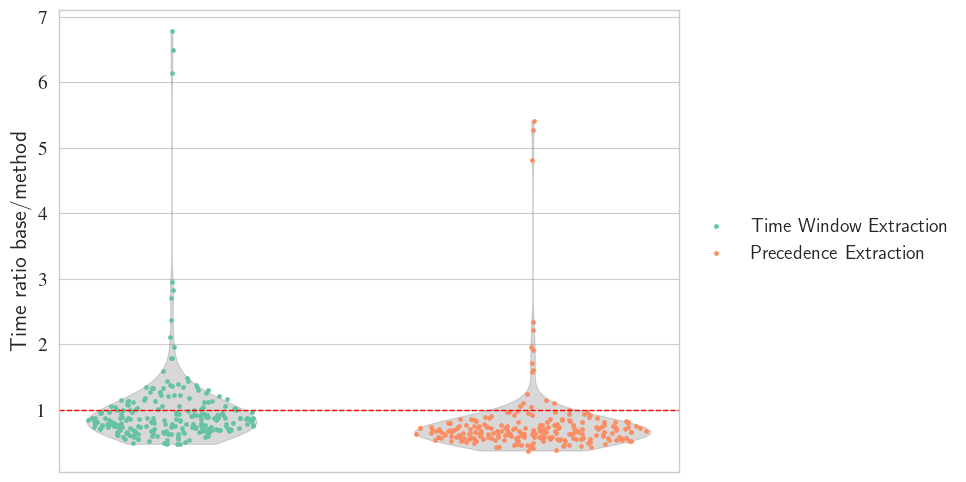

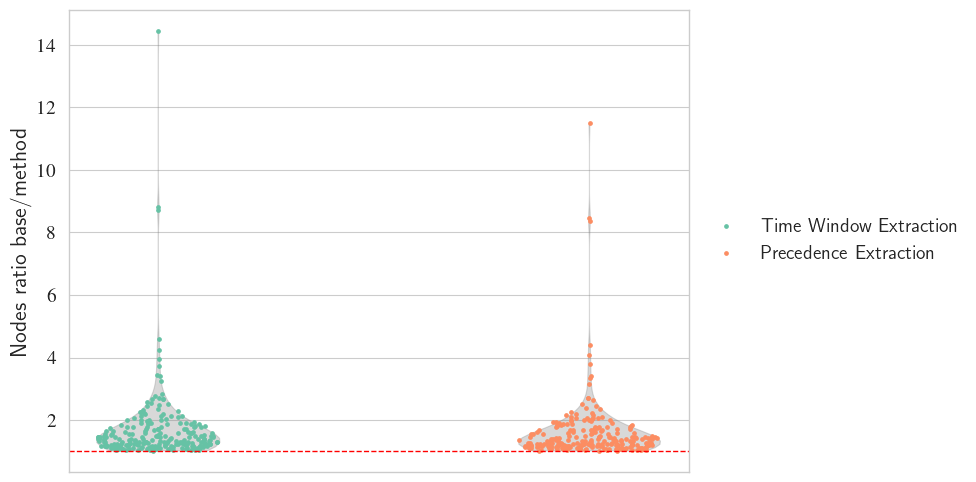

In [359]:
dicTime = {}
dicNodes = {}
dicTime[f"Time Window Extraction"] = df["time_pct_TW"].to_list()
dicTime[f"Precedence Extraction"] = df["time_pct_Pred"].to_list()
dicNodes[f"Time Window Extraction"] = df["nodes_pct_TW"].to_list()
dicNodes[f"Precedence Extraction"] = df["nodes_pct_Pred"].to_list()
multi_sina_plot(dicTime, show_violin=True, offset=1, scaling=0.2, n_bins=100, title = "Time ratio base/method")
multi_sina_plot(dicNodes, show_violin=True, offset=1, scaling=0.2, n_bins=100, title = "Nodes ratio base/method")

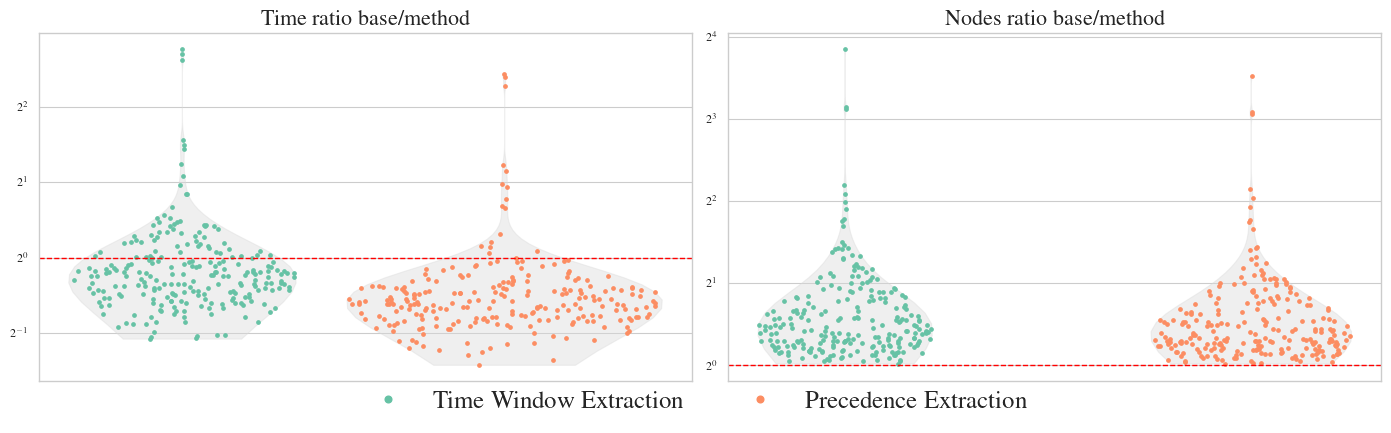

In [360]:

multi_sina_plot_dual(dicTime, dicNodes, show_violin=True, offset=1, scaling=0.3, n_bins=100, title_left="Time ratio base/method", title_right="Nodes ratio base/method",filename="complete_time_nodes.pdf")


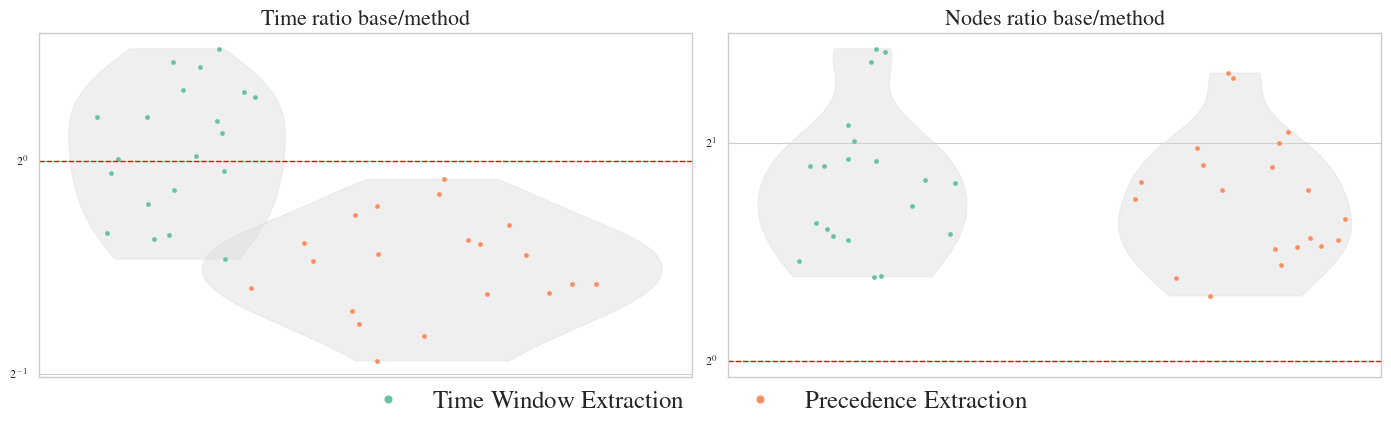

In [361]:
dictTime = {}
dictNodes = {}
bdf = df[df["loadfactor"] == 1]
bdf = bdf[bdf["n"] == 40]
bdf = bdf[bdf["mddSize"] == 32]
dicTime[f"Time Window Extraction"] = bdf["time_pct_TW"].to_list()
dicTime[f"Precedence Extraction"] = bdf["time_pct_Pred"].to_list()
#dicTime[f"TW-sMDD"] = df["time_pct_TWSMDD"].to_list()
#dicTime[f"Pred-sMDD"] = df["time_pct_PredSMDD"].to_list()
dicNodes[f"Time Window Extraction"] = bdf["nodes_pct_TW"].to_list()
dicNodes[f"Precedence Extraction"] = bdf["nodes_pct_Pred"].to_list()
multi_sina_plot_dual(dicTime, dicNodes, show_violin=True, offset=1, scaling=0.3, n_bins=100, title_left="Time ratio base/method", title_right="Nodes ratio base/method",filename="complete_time_nodes_n40_mdd32.pdf")

In [362]:
def plot_per_spec(df: pd.DataFrame, spec: str, title: str = ""):
    dictTime = {}
    dictNodes = {}
    for size in df[spec].unique():
        df_size = df[df[spec] == size]
        dicTimeSub = {}
        dicNodesSub = {}
        dicTimeSub[f"Time Window Extraction"] = df_size["time_pct_TW"].to_list()
        dicTimeSub[f"Precedence Extraction"] = df_size["time_pct_Pred"].to_list()
        dicNodesSub[f"Time Window Extraction"] = df_size["nodes_pct_TW"].to_list()
        dicNodesSub[f"Precedence Extraction"] = df_size["nodes_pct_Pred"].to_list()
        dictTime[title+ " = " +str(size)] = dicTimeSub
        dictNodes[title+ " = " +str(size)] = dicNodesSub
    multi_sina_plot_multi(dictNodes, 1, 0.25, n_bins=100, show_violin=True, shared_scale=True, filename="nodes_"+title+".pdf")
    multi_sina_plot_multi(dictTime, 1, 0.25, n_bins=100, show_violin=True, shared_scale=True, filename="time_"+title+".pdf")

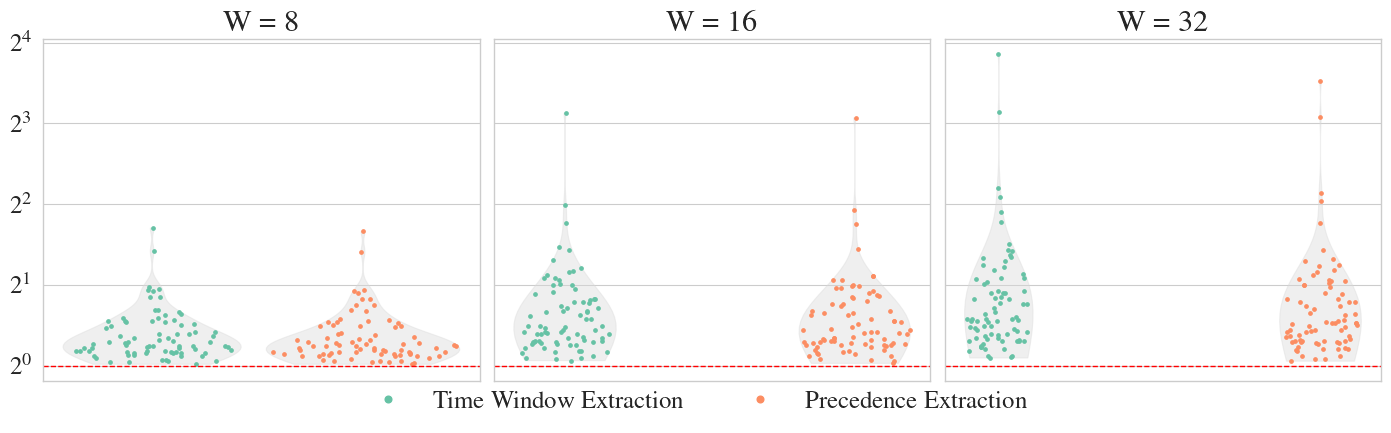

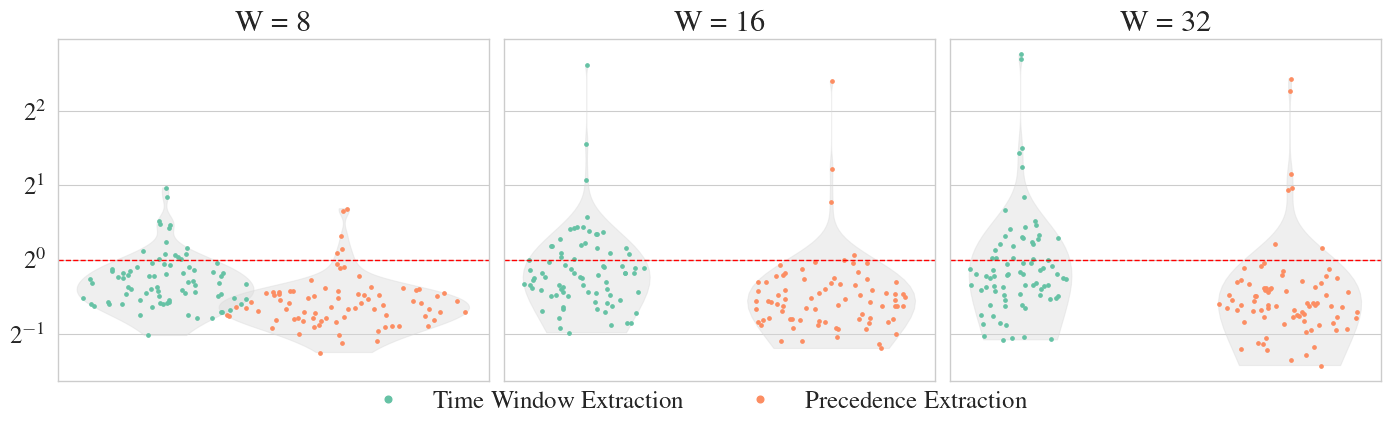

In [363]:
plot_per_spec(df, "mddSize", "W")

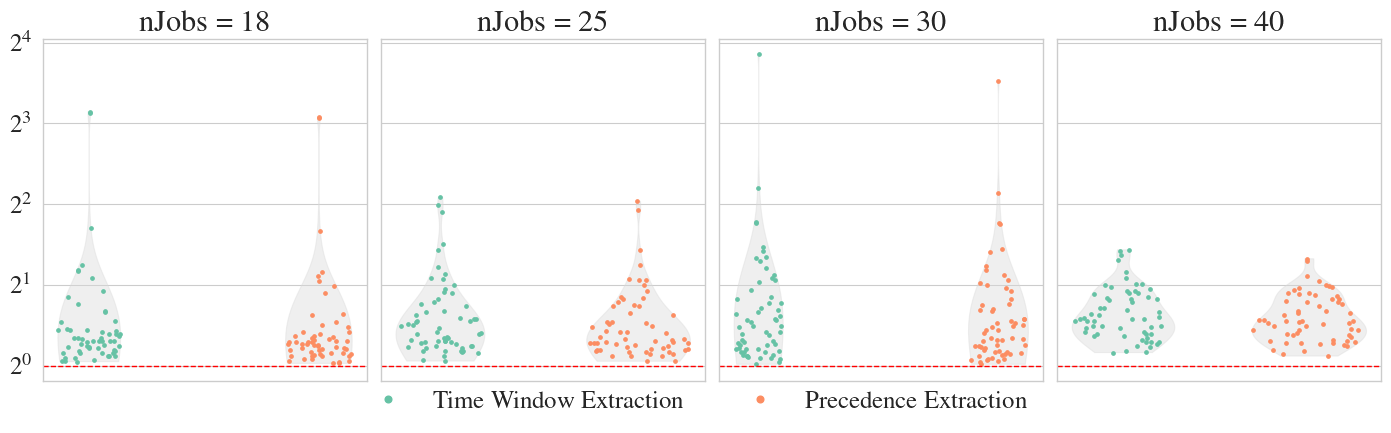

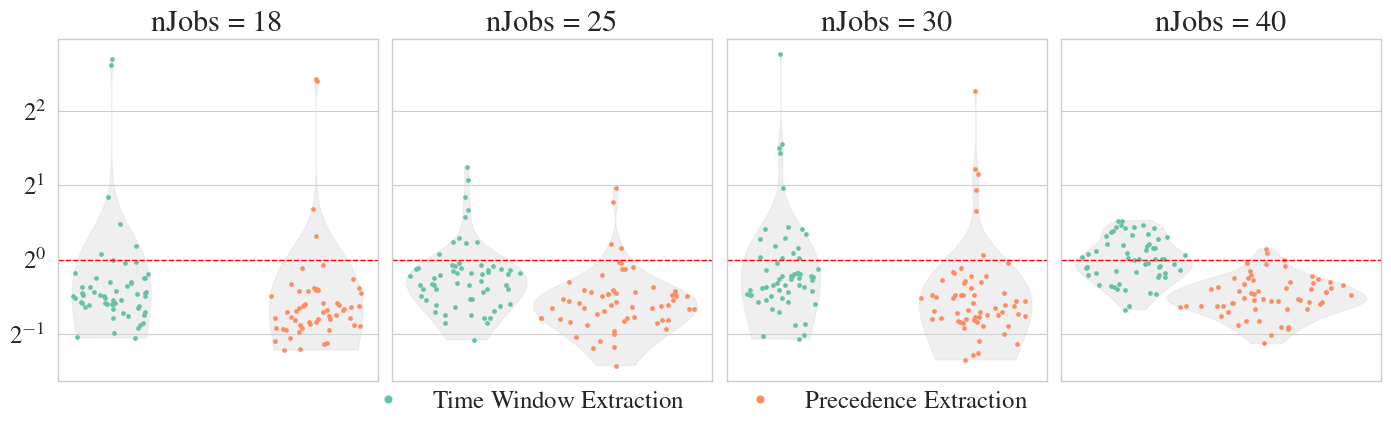

In [364]:
plot_per_spec(df, "n", "nJobs")

In [365]:
def plot_per_spec(df: pd.DataFrame, spec: str, title: str = ""):
    dictTime = {}
    dictNodes = {}

    for size in df[spec].unique():
        df_size = df[df[spec] == size]

        dictNodes[f"{title} = {size}"] = {
            "Relaxed BC Filtering": df_size["nodes_pct_TW"].to_list(),
            "Precedence Extraction": df_size["nodes_pct_Pred"].to_list(),
        }
        dictTime[f"{title} = {size}"] = {
            "Relaxed BC Filtering": df_size["time_pct_TW"].to_list(),
            "Precedence Extraction": df_size["time_pct_Pred"].to_list(),
        }

    multi_sina_plot_grid(
        dictNodes,
        dictTime,
        shared_cols=len(dictNodes),
        scaling=0.25,
        n_bins=150,
        show_violin=True,
        filename= title+"_nodes_time_grid.pdf",
    )


def multi_sina_plot_grid(
    dictNodes,
    dictTime,
    shared_cols,
    offset=1,
    scaling=5,
    n_bins=512,
    show_violin=False,
    figsize=(18,10),
    filename=None,
):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import gaussian_kde

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
    })

    titles = list(dictNodes.keys())  # W = XXX
    labels = list(next(iter(dictNodes.values())).keys())
    palette = sns.color_palette("Set2", n_colors=len(labels))

    fig, axes = plt.subplots(
        2, shared_cols,
        figsize=figsize,
        sharey=False
    )

    # Top row shared scale
    for j in range(1, shared_cols):
        axes[0, j].sharey(axes[0, 0])
    # Bottom row shared scale
    for j in range(1, shared_cols):
        axes[1, j].sharey(axes[1, 0])


    def plot_sina(ax, values_dict, title=None, show_label = True):
        off = 0
        for color, label in zip(palette, labels):
            vals = np.asarray(values_dict[label])

            kde = gaussian_kde(vals)
            pts = np.linspace(vals.min(), vals.max(), n_bins)
            envelope = kde(pts) * scaling
            widths = np.interp(vals, pts, envelope)

            x = off + (np.random.rand(len(vals))*2 - 1) * widths

            # Violin
            if show_violin:
                ax.fill(
                    np.concatenate([off + envelope, off - envelope[::-1]]),
                    np.concatenate([pts, pts[::-1]]),
                    color="0.85", alpha=0.4
                )

            # Scatter
            ax.plot(x, vals, '.', color=color)
            off += offset

        # Add the red dashed line at y=1
        ax.axhline(1, color="red", linestyle="--", linewidth=1.2)

        # Only put titles on top row
        if title is not None:
            ax.set_title(title, fontsize=22)

        ax.set_xticks([])
        ax.set_yscale("log", base=2)
        ax.grid(axis="y", which="both", linestyle="--", alpha=0.5)
        ax.tick_params(axis='y', which='both', labelleft=show_label, labelsize=22)


    # ---- Row 1: Nodes (with titles) ----
    label = True
    for ax, key in zip(axes[0], titles):
        plot_sina(ax, dictNodes[key], title=key, show_label=label)
        label = False

    axes[0, 0].set_ylabel("Node Ratio", fontsize=22)

    # ---- Row 2: Time (NO titles) ----
    label = True
    for ax, key in zip(axes[1], titles):
        plot_sina(ax, dictTime[key], title=None, show_label=label)
        label = False

    axes[1, 0].set_ylabel("Time Ratio", fontsize=22)

    # ---- Legend ----
    fig.legend(
        handles=[
            plt.Line2D([], [], marker='o', linestyle='', color=palette[i])
            for i in range(len(labels))
        ],
        labels=labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(labels),
        fontsize=22,
        frameon=False,
    )

    fig.tight_layout()

    if filename:
        plt.savefig(filename, bbox_inches="tight")

    plt.show()


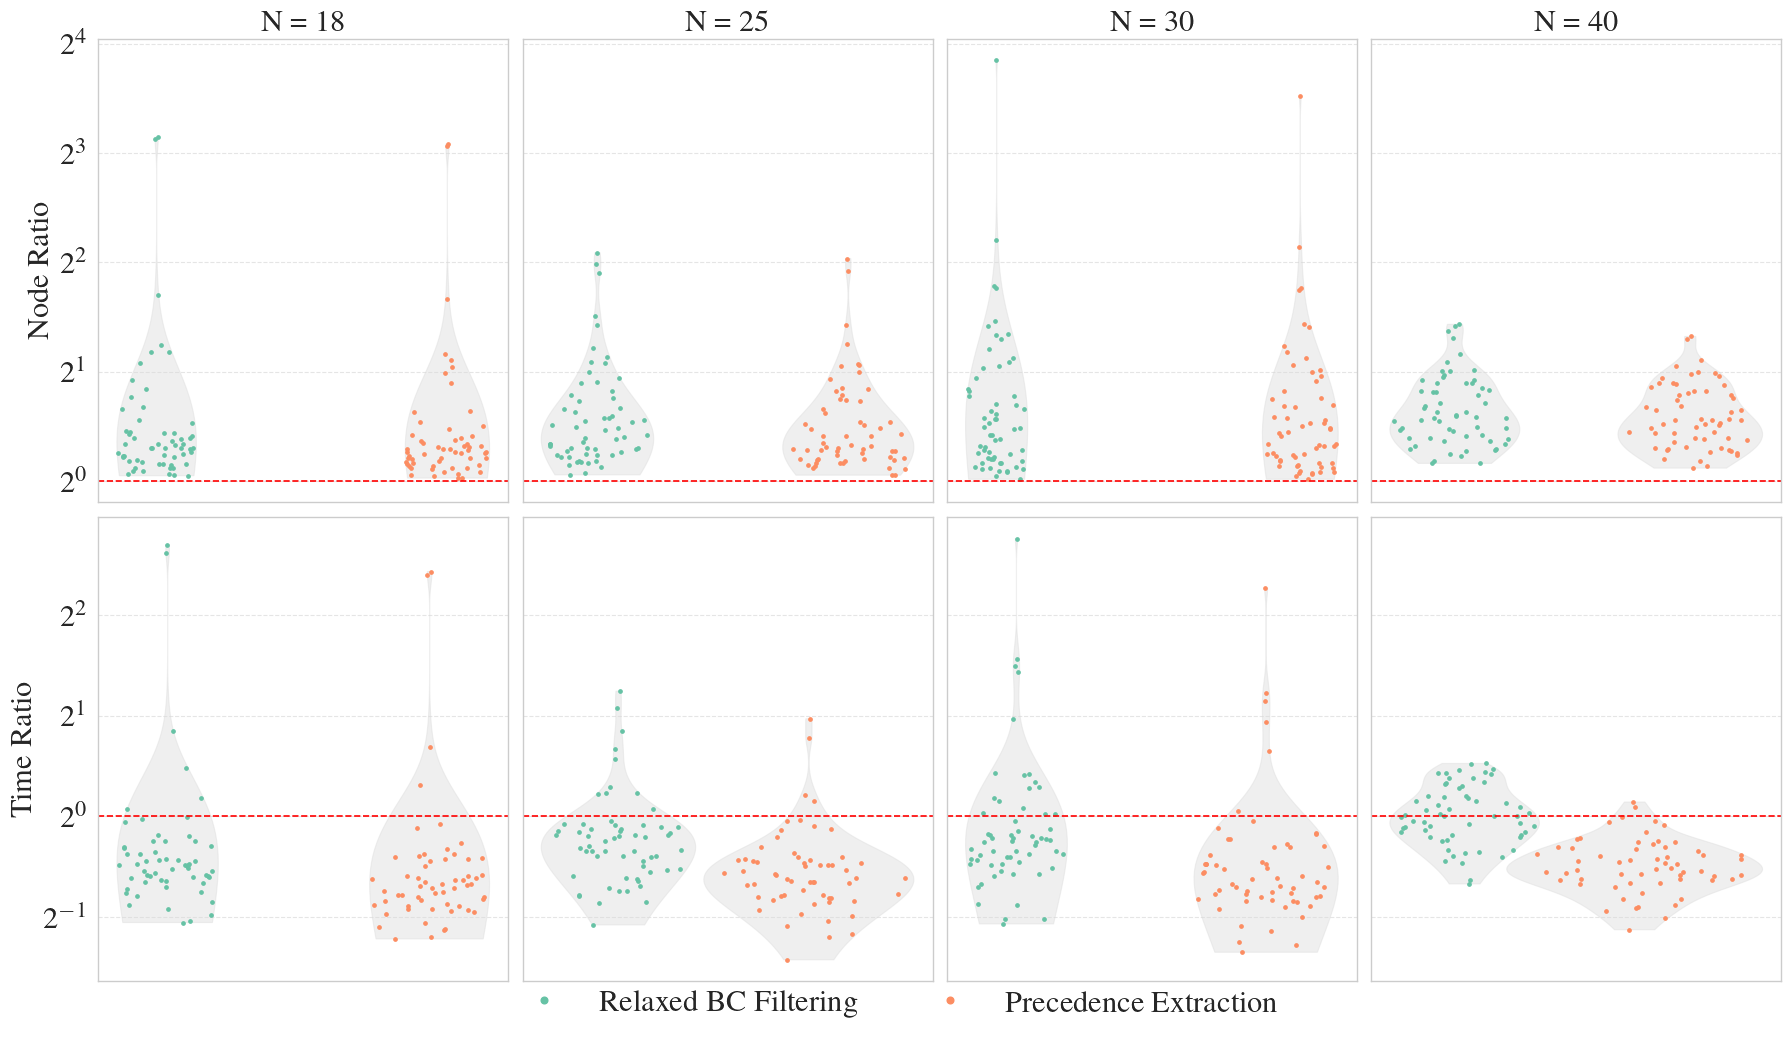

In [366]:
plot_per_spec(df, "n", "N")


In [367]:
def plot_per_spec(df: pd.DataFrame, spec: str):
    for size in df[spec].unique():
        print(size)
        df_size = df[df[spec] == size]
        dicTime = {}
        dicNodes = {}
        dicTime[f"Time Window Extraction"] = df_size["time_pct_TW"].to_list()
        dicTime[f"Precedence Extraction"] = df_size["time_pct_Pred"].to_list()
        #dicTime[f"TW-sMDD"] = df_size["time_pct_TWSMDD"].to_list()
        #dicTime[f"Pred-sMDD"] = df_size["time_pct_PredSMDD"].to_list()
        dicNodes[f"Time Window Extraction"] = df_size["nodes_pct_TW"].to_list()
        dicNodes[f"Precedence Extraction"] = df_size["nodes_pct_Pred"].to_list()
        #dicNodes[f"TW-sMDD"] = df_size["nodes_pct_TWSMDD"].to_list()
        #dicNodes[f"Pred-sMDD"] = df_size["nodes_pct_PredSMDD"].to_list()
        multi_sina_plot(dicTime, show_violin=True, offset=1, scaling=0.1, n_bins=100, title = "Time ratio base/method")
        multi_sina_plot(dicNodes, show_violin=True, offset=1, scaling=0.1, n_bins=100, title = "Nodes ratio base/method")

# Analysis per MDDSize

8


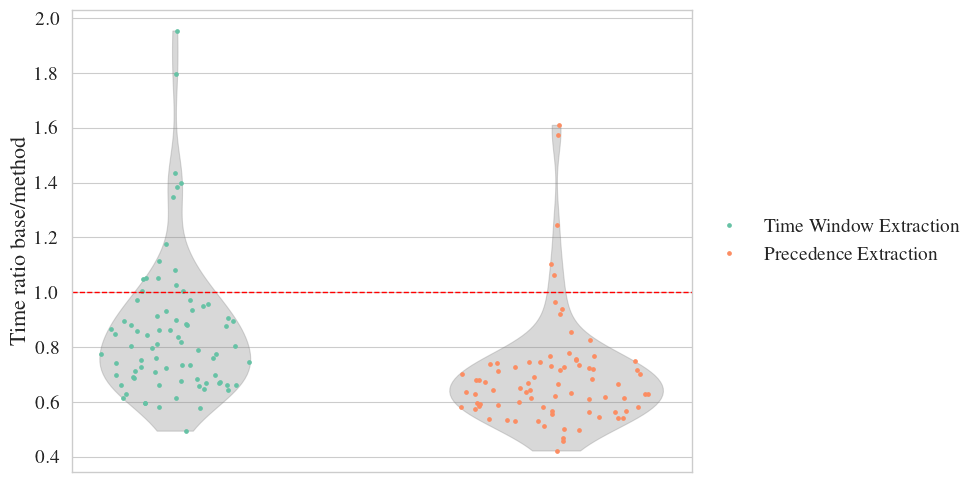

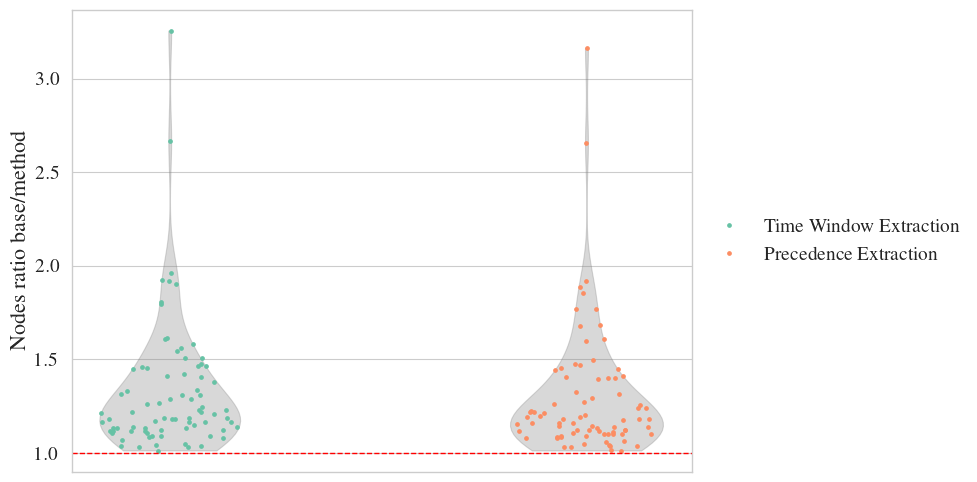

16


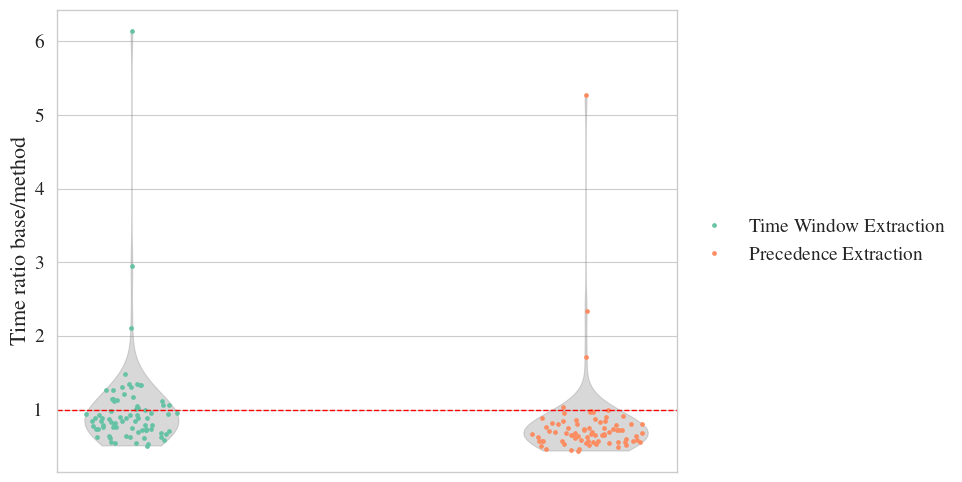

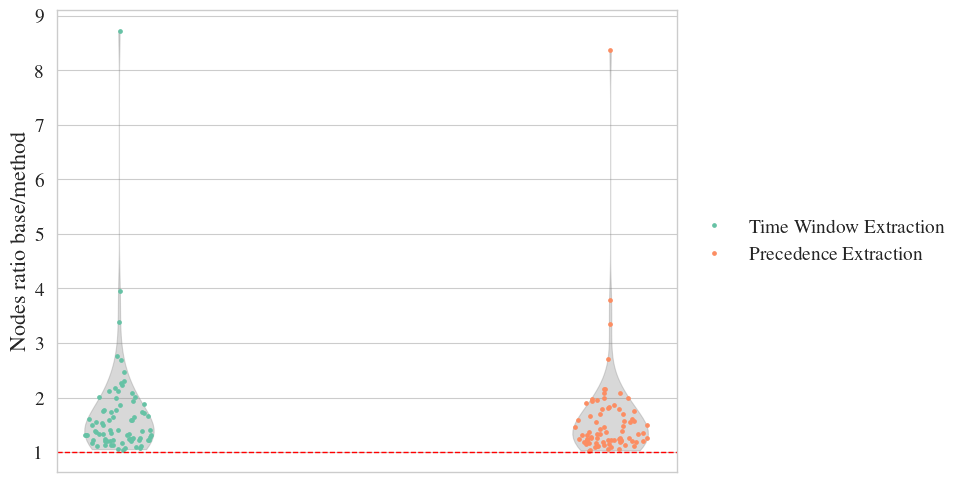

32


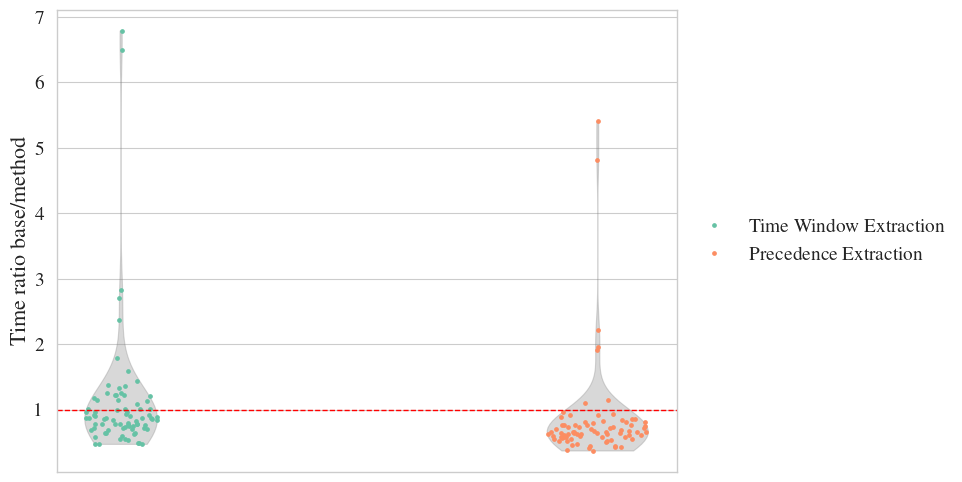

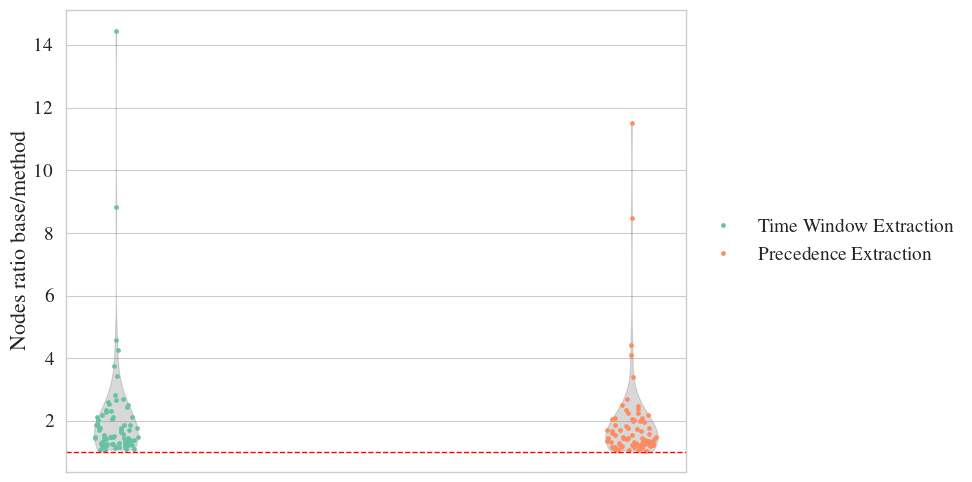

In [368]:
plot_per_spec(df, "mddSize")

# Analysis per problem size

18


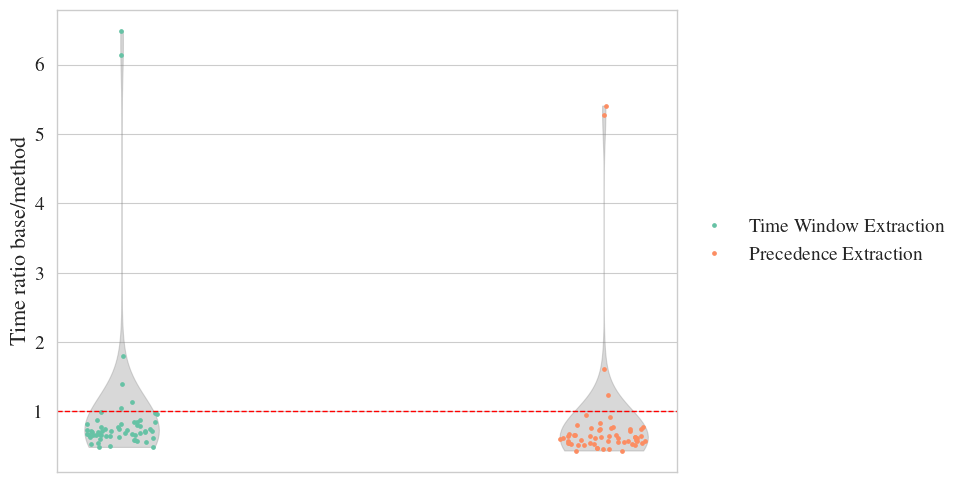

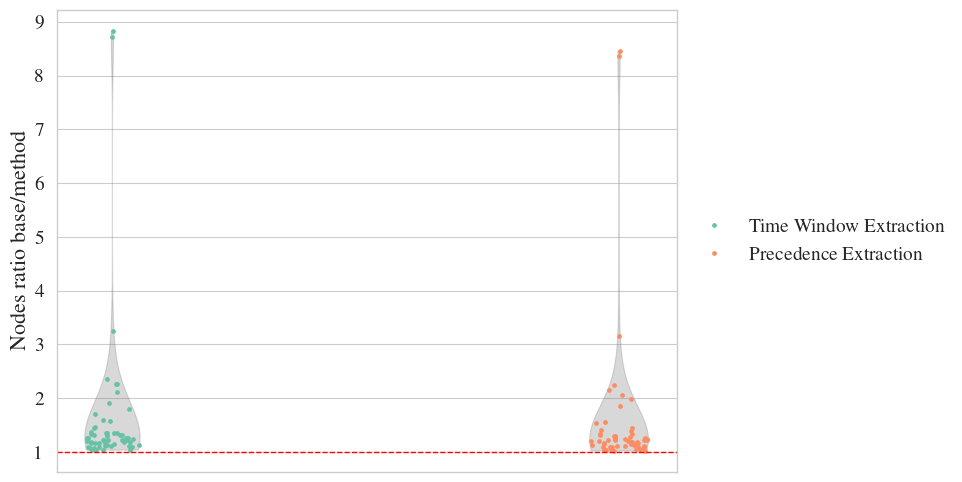

25


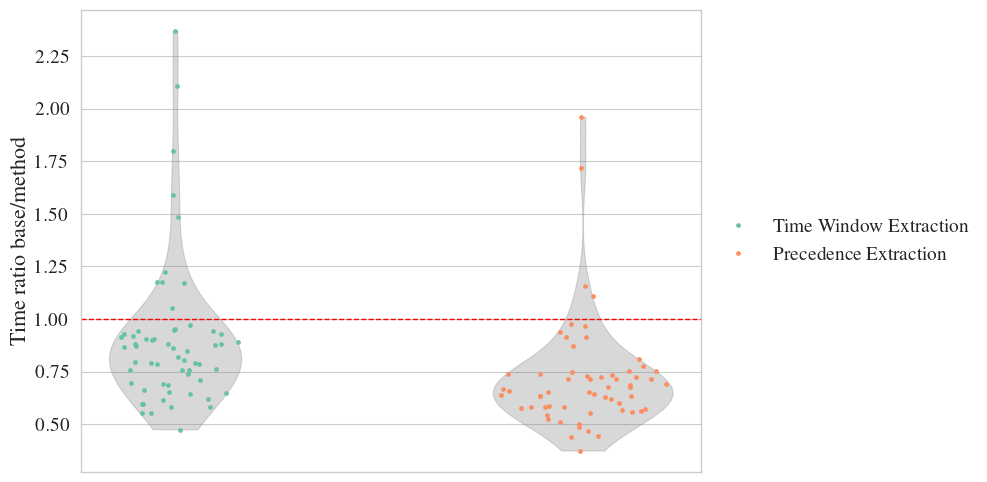

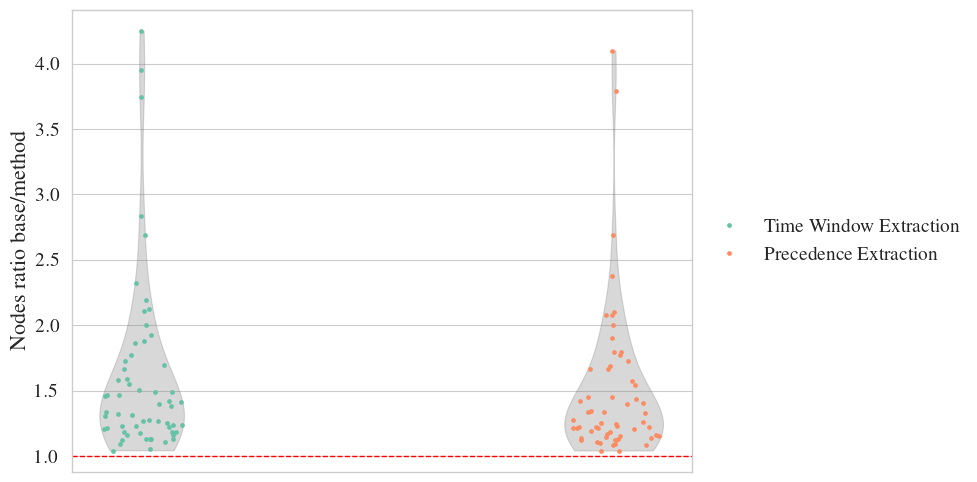

30


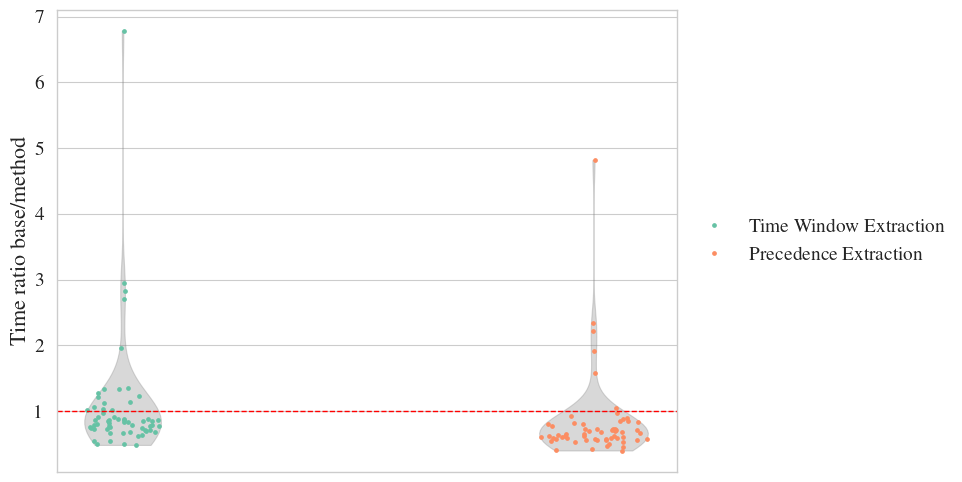

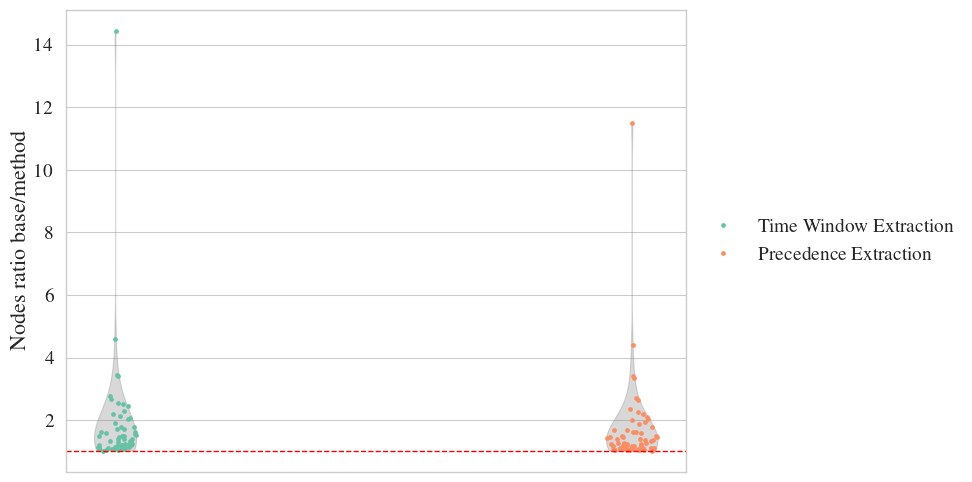

40


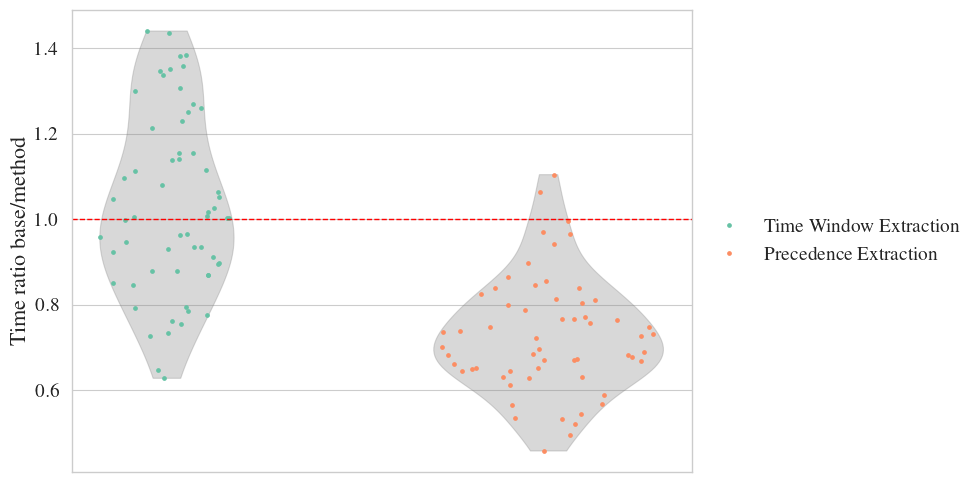

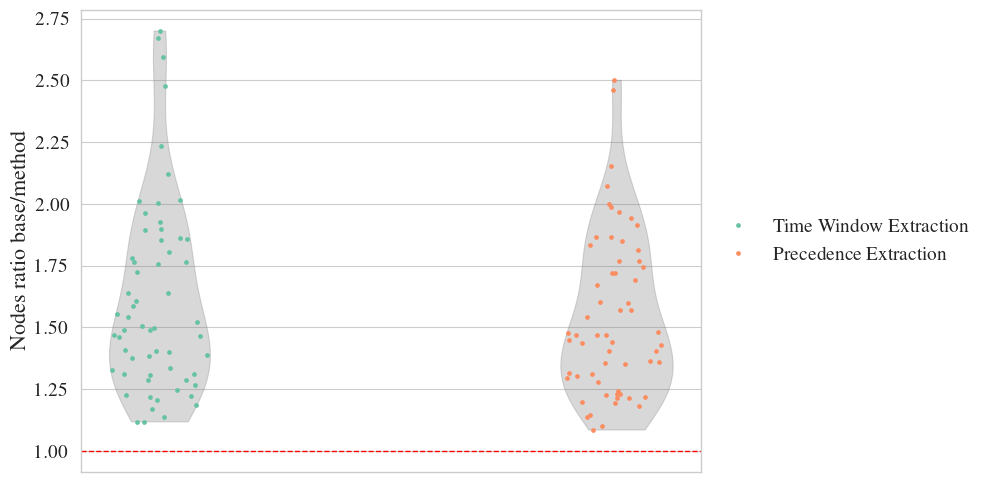

In [369]:
plot_per_spec(df, "n")

In [370]:
def plot_per_specTW(df: pd.DataFrame, spec: str):

    dicTime = {}
    dicNodes = {}
    for size in df[spec].unique():
        print(size)
        df_size = df[df[spec] == size]
        dicTime[f"Time Window Extraction "+ spec +" : "+ str(size)] = df_size["time_pct_TW"].to_list()
        dicNodes[f"Time Window Extraction "+ spec +" : "+ str(size)] = df_size["nodes_pct_TW"].to_list()
    multi_sina_plot(dicTime, show_violin=True, offset=1, scaling=0.1, n_bins=100, title = "Time ratio base/method")
    multi_sina_plot(dicNodes, show_violin=True, offset=1, scaling=0.1, n_bins=100, title = "Nodes ratio base/method")

8
16
32


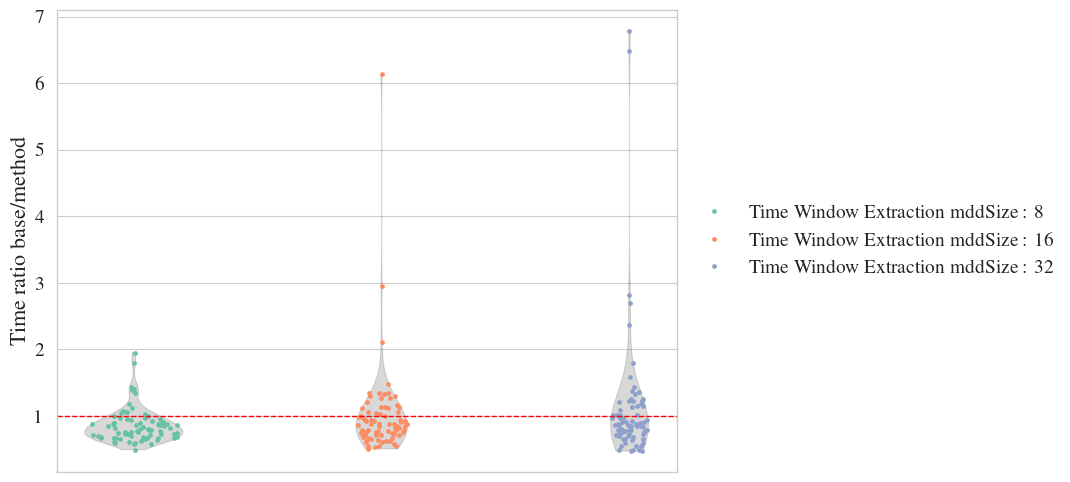

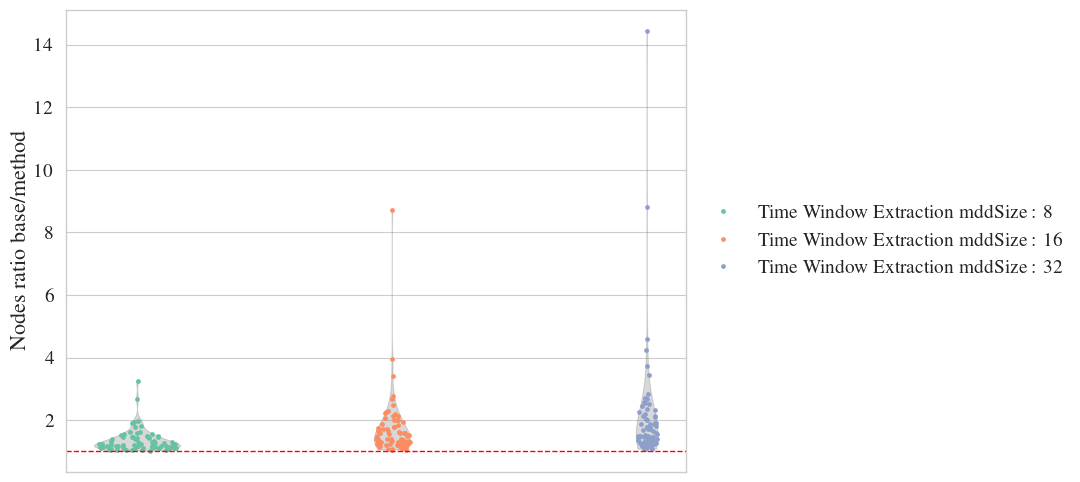

In [371]:
plot_per_specTW(df, "mddSize")

# Analysis per loadFactor

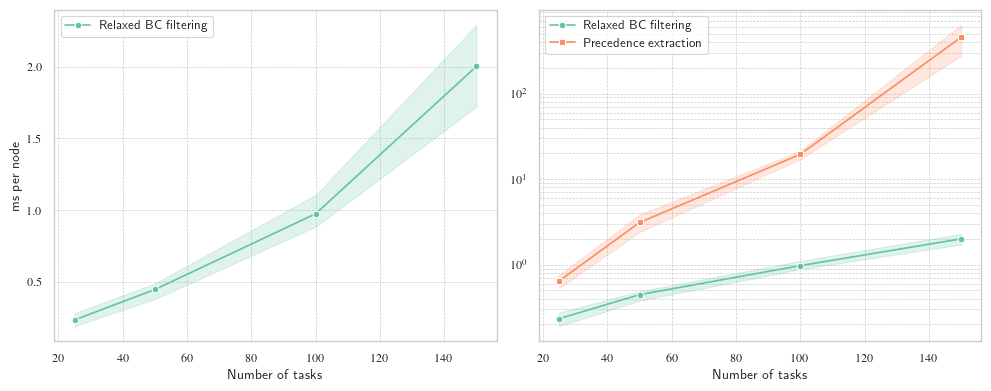

In [372]:
# Load data
dfBPS = pd.read_csv("jitbps", sep=",")
dfBPS["sbp"] = dfBPS["nbNodes"] / dfBPS["time"]

# Set Seaborn style for publication
sns.set_context("paper")  # "talk", "poster", "paper"
sns.set_style("whitegrid")  # clean background
palette = sns.color_palette("Set2")  # soft, distinct colors

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# --- Left subplot: only TW, linear scale ---
sns.lineplot(
    data=dfBPS[dfBPS["TW"] == True],
    x="n", y="sbp",
    marker="o",
    ax=axes[0],
    color=palette[0],
    label="Relaxed BC filtering"
)
axes[0].set_xlabel("Number of tasks")
axes[0].set_ylabel("ms per node")
axes[0].legend()
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# --- Right subplot: TW and Pred, log scale ---
sns.lineplot(
    data=dfBPS[dfBPS["TW"] == True],
    x="n", y="sbp",
    marker="o",
    ax=axes[1],
    color=palette[0],
    label="Relaxed BC filtering"
)
sns.lineplot(
    data=dfBPS[dfBPS["TW"] == False],
    x="n", y="sbp",
    marker="s",
    ax=axes[1],
    color=palette[1],
    label="Precedence extraction"
)
axes[1].set_xlabel("Number of tasks")

axes[1].set_ylabel("")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)


# Adjust layout
plt.tight_layout()

# Save figure in high resolution
plt.savefig("sbp.pdf", dpi=300)
plt.show()

     timeTW  timePred  timeBase
219   41662     78583     60001
220   47947     81455     60001
223   52002     71495     60001
224   43450     73932     60001
225   62088     92136     60001
227   59525     89668     60001
228   51950     81278     60001
229   54724     92413     60001
230   44191     69390     60001
232   48758     66778     60001
237   58984     77685     60001
238   65849     89520     60001
240   82560    115010     60001
241   47600     63654     60001
242   52682     83122     60001
243   68991     90652     60001
244   75752    106065     60001
247   62351     78334     60001
248   77345    101924     60002
249   76445     97787     60001


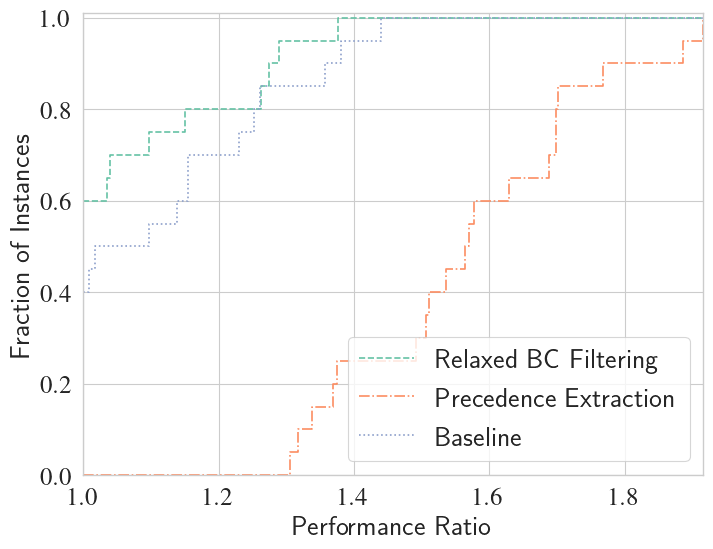

In [373]:
import perfprof
linestyles = ['--', '-.', ':']
df = df[df["mddSize"] == 32]
df = df[df["n"] == 40]
node_df = df[["timeTW", "timePred","timeBase"]]
print(node_df)
palette = sns.color_palette("Set2")  # soft, distinct colors
plt.figure(figsize=(8, 6))
perfprof.perfprof(node_df,linestyles)
# set2 as color scheme

plt.legend(['Relaxed BC Filtering', 'Precedence Extraction', 'Baseline'], fontsize = 20, loc='lower right')
plt.xlabel("Performance Ratio", fontsize=20)
plt.ylabel("Fraction of Instances", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot()
plt.savefig("perfprof_time.pdf", dpi=300)
